In [1]:
import os
import sys
import math
from functools import partial
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

from src.models import HED
from src.losses import balanced_cross_entropy
from src.metrics import dice_coefficient, iou, accuracy
from src.dataset import CustomImageDataGenerator
from src.config import *

ELEVATION_TIF_DIR = '/Users/mikeskaug/Documents/personal/ridges/data/high_ridge_terrain/Colorado/manual/tif'
MASK_TIF_DIR = '/Users/mikeskaug/Documents/personal/ridges/data/high_ridge_terrain/Colorado/manual/mask'

In [2]:
def load_subset(data_dir, N=None, frac=None, random=True, seed=1):
    '''
    Load a random subset of the images in a directory and return as an Nx256x256x1 numpy array
    '''
    np.random.seed(seed=seed)
    files = os.listdir(data_dir)
    if N:
        num_files = N
    elif frac:
        num_files = int(frac*len(files))
        
    if random:
        subset_files = np.random.choice(files, size=num_files, replace=False)
    else:
        subset_files = files[:num_files-1]
    
    data = []
    for fl in subset_files:
        im = Image.open(os.path.join(data_dir, fl))
        data.append(np.array(im))

    return np.expand_dims(np.stack(data), axis=3)

def standardize(featurewise_std, batch):
    batch -= batch.mean(axis=(1,2), keepdims=True)
    batch /= featurewise_std

    return batch

In [4]:
input_img = Input((*IMAGE_SIZE, 1), name='img')
model = HED(input_img)
model.load_weights('/Users/mikeskaug/Documents/personal/ridges/output/checkpoint/2020-06-18T21:32/weights.20-0.07.hdf5')

In [22]:
# prepare image generators
batch_size = 80
subset = load_subset(ELEVATION_TIF_DIR, frac=1)
featurewise_std = subset.std()

files = os.listdir(ELEVATION_TIF_DIR)
np.random.shuffle(files)

generator = CustomImageDataGenerator(
    ELEVATION_TIF_DIR, 
    MASK_TIF_DIR, 
    files, 
    batch_size=batch_size, 
    standardize_batch=partial(standardize, featurewise_std), 
    rescale_y=1/255,
    n_outputs=1
)
test_data = generator.__getitem__(0)

In [26]:
predict_batch = test_data[0]
masks = test_data[1][0]
predictions = model.predict_on_batch(predict_batch)

In [68]:
accuracy(masks, (predictions[-1] > 0.90))

<tf.Tensor: id=2755, shape=(), dtype=float64, numpy=0.9412576675415039>

In [67]:
dice_coef = dice_coefficient(masks, (predictions[-1] > 0.90))
np.mean(dice_coef)

0.4167113363181816

In [90]:
x = iou(masks, (predictions[-1] > 0.987))
print(f'IOU: {x}')

IOU: 0.3239213185783261


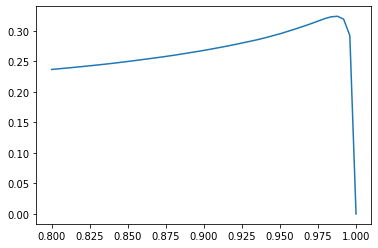

In [85]:
thresholds = np.linspace(0.8, 1)
iou_vals = [iou(masks, (predictions[-1] > thresh)).numpy() for thresh in thresholds]
sns.lineplot(thresholds, iou_vals)

# Evaluate heuristic model

In [30]:
from src.transforms import ridges

In [53]:
generator = CustomImageDataGenerator(
    ELEVATION_TIF_DIR, 
    MASK_TIF_DIR, 
    files, 
    batch_size=batch_size,
    rescale_y=1/255,
    n_outputs=1
)
test_data = generator.__getitem__(0)

In [54]:
heuristic_pred = np.zeros(test_data[0].shape[:-1])
for sample_id in range(test_data[0].shape[0]):
    heuristic_pred[sample_id] = ridges(np.squeeze(test_data[0][sample_id])).astype(float)

In [ ]:
accuracy(masks, heuristic_pred[:, :, :, np.newaxis])

In [56]:
dice_coef = dice_coefficient(masks, heuristic_pred[:, :, :, np.newaxis])
np.mean(dice_coef)

0.43456589646514276

In [ ]:
x = iou(masks, heuristic_pred[:, :, :, np.newaxis])
print(f'IOU: {x}')

# Compare examples

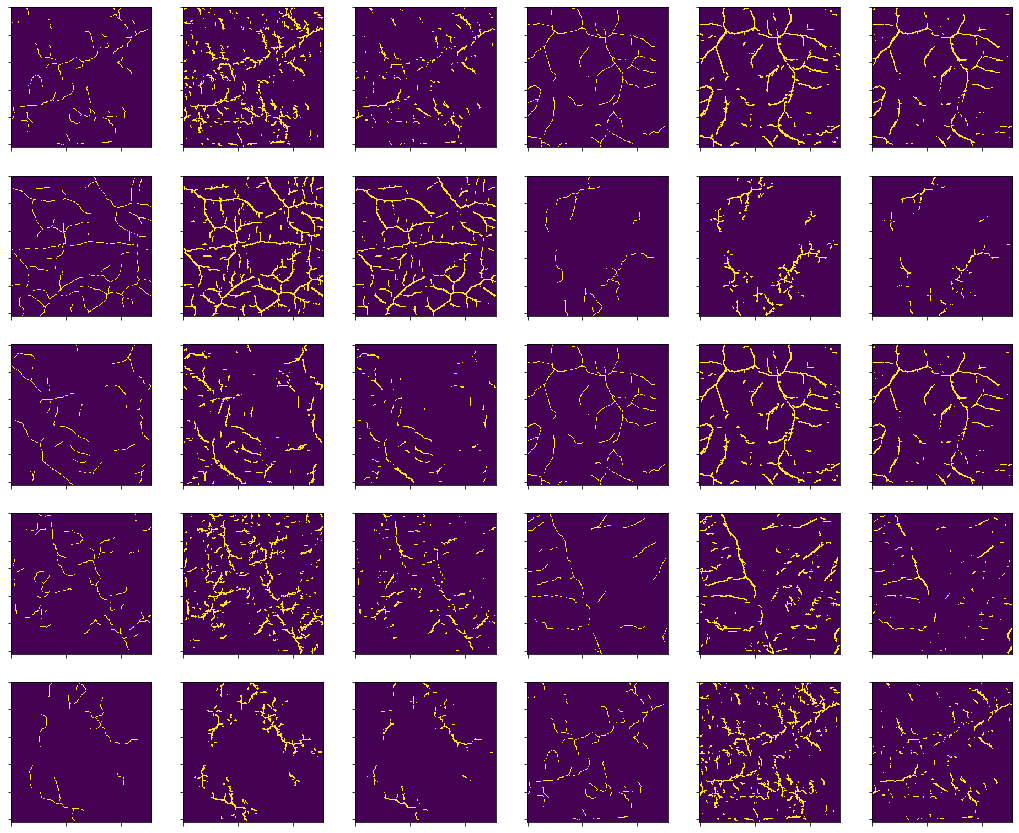

In [93]:
all_images = np.empty((30,256,256), dtype=predictions[-1].dtype)
all_images[0::3,:,:] = np.squeeze(masks[:10])
all_images[1::3,:,:] = heuristic_pred[:10]
all_images[2::3,:,:] = np.squeeze(predictions[-1][:10]) > 0.987

grid_width = 6
grid_height = int(all_images.shape[0] / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(18, 15))
for i in range(grid_height*grid_width):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow((all_images[i, :, :].reshape((256, 256))), cmap='viridis', ) #vmin=0, # coolwarm
    ax.set_yticklabels([])
    ax.set_xticklabels([])